In [1]:
import numpy as np
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Flatten, Dense, Dropout
from tensorflow.python.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator


DATASET_PATH  = './sample'
IMAGE_SIZE    = (256, 256)
CROP_LENGTH   = 224
NUM_CLASSES   = 2
BATCH_SIZE    = 8  # try reducing batch size or freeze more layers if your GPU runs out of memory
FREEZE_LAYERS = 2  # freeze the first this many layers for training
NUM_EPOCHS    = 20
WEIGHTS_FINAL = 'model-cropped-final.h5'


def random_crop(img, random_crop_size):
    # Note: image_data_format is 'channel_last'
    assert img.shape[2] == 3
    height, width = img.shape[0], img.shape[1]
    dy, dx = random_crop_size
    x = np.random.randint(0, width - dx + 1)
    y = np.random.randint(0, height - dy + 1)
    return img[y:(y+dy), x:(x+dx), :]


def crop_generator(batches, crop_length):
    """Take as input a Keras ImageGen (Iterator) and generate random
    crops from the image batches generated by the original iterator.
    """
    while True:
        batch_x, batch_y = next(batches)
        batch_crops = np.zeros((batch_x.shape[0], crop_length, crop_length, 3))
        for i in range(batch_x.shape[0]):
            batch_crops[i] = random_crop(batch_x[i], (crop_length, crop_length))
        yield (batch_crops, batch_y)


train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   channel_shift_range=10,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
train_batches = train_datagen.flow_from_directory(DATASET_PATH + '/train',
                                                  target_size=IMAGE_SIZE,
                                                  interpolation='bicubic',
                                                  class_mode='categorical',
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE)

valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
valid_batches = valid_datagen.flow_from_directory(DATASET_PATH + '/valid',
                                                  target_size=IMAGE_SIZE,
                                                  interpolation='bicubic',
                                                  class_mode='categorical',
                                                  shuffle=False,
                                                  batch_size=BATCH_SIZE)

train_crops = crop_generator(train_batches, CROP_LENGTH)
valid_crops = crop_generator(valid_batches, CROP_LENGTH)

Found 2000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [ ]:
%pylab inline

i = 1

for img in train_crops:
    if i==1:
        break
    imgplot = plt.imshow(img)
    plt.show()
    pause

In [ ]:
img2 = img[0][0]
imgplot = plt.imshow(img2)
plt.show()



In [ ]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img=mpimg.imread('./sample/train/dogs/dog.2.jpg')
imgplot = plt.imshow(img)
plt.show()

In [2]:
# show class indices
print('****************')
for cls, idx in train_batches.class_indices.items():
    print('Class #{} = {}'.format(idx, cls))
print('****************')


****************
Class #0 = cats
Class #1 = dogs
****************


In [4]:
# build our classifier model based on pre-trained ResNet50:
# 1. we don't include the top (fully connected) layers of ResNet50
# 2. we add a DropOut layer followed by a Dense (fully connected)
#    layer which generates softmax class score for each class
# 3. we compile the final model using an Adam optimizer, with a
#    low learning rate (since we are 'fine-tuning')
net = ResNet50(include_top=False, weights='imagenet', input_tensor=None,
               input_shape=(CROP_LENGTH,CROP_LENGTH,3))
x = net.output
x = Flatten()(x)
x = Dropout(0.5)(x)
output_layer = Dense(NUM_CLASSES, activation='softmax', name='softmax')(x)
net_final = Model(inputs=net.input, outputs=output_layer)
for layer in net_final.layers[:FREEZE_LAYERS]:
    layer.trainable = False
for layer in net_final.layers[FREEZE_LAYERS:]:
    layer.trainable = True
net_final.compile(optimizer=Adam(lr=1e-5),
                  loss='categorical_crossentropy', metrics=['accuracy'])
print(net_final.summary())

# train the model
net_final.fit_generator(train_crops,
                        steps_per_epoch = train_batches.samples // BATCH_SIZE,
                        validation_data = valid_crops,
                        validation_steps = valid_batches.samples // BATCH_SIZE,
                        epochs = NUM_EPOCHS)

# save trained weights
net_final.save(WEIGHTS_FINAL)

94658560/94653016 [==============================] - 12s 0us/step
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
___________________________________________

Epoch 1/20
250/250 [==============================] - 5324s 21s/step - loss: 0.9786 - acc: 0.7020 - val_loss: 0.1474 - val_acc: 0.9413
Epoch 2/20
250/250 [==============================] - 4429s 18s/step - loss: 0.4387 - acc: 0.8650 - val_loss: 0.0782 - val_acc: 0.9738
Epoch 3/20
250/250 [==============================] - 4435s 18s/step - loss: 0.3549 - acc: 0.8995 - val_loss: 0.0774 - val_acc: 0.9750
Epoch 4/20
250/250 [==============================] - 4429s 18s/step - loss: 0.2656 - acc: 0.9210 - val_loss: 0.0749 - val_acc: 0.9738
Epoch 5/20
250/250 [==============================] - 4439s 18s/step - loss: 0.2253 - acc: 0.9300 - val_loss: 0.0395 - val_acc: 0.9862
Epoch 6/20
250/250 [==============================] - 4445s 18s/step - loss: 0.2276 - acc: 0.9310 - val_loss: 0.0457 - val_acc: 0.9850
Epoch 7/20
250/250 [==============================] - 17019s 68s/step - loss: 0.1982 - acc: 0.9410 - val_loss: 0.0510 - val_acc: 0.9825
Epoch 8/20
250/250 [==============================] - 

In [2]:
#load the trained model into memory
from tensorflow.python.keras.models import load_model
WEIGHTS_FINAL = 'model-cropped-final.h5'
loaded_model = load_model(WEIGHTS_FINAL)

Populating the interactive namespace from numpy and matplotlib


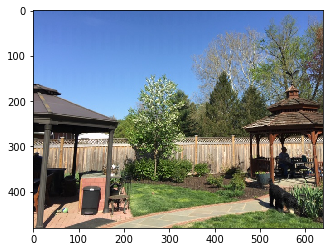

In [46]:
#run the trained model against a picture
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
#myTestImg=mpimg.imread('./sample/train/dogs/dog.201.jpg')
myTestImg=mpimg.imread('./sample/test/test12.jpg')
imgplot = plt.imshow(myTestImg)
plt.show()


In [60]:
def dwrite(s, fout):
    print(s)
    fout.write(s)
    fout.write('\n')

# from tensorflow.python.keras.backend import resize_images
import cv2
fout = open('./sample/output/inference.csv','w')

dwrite('tail number, prediction', fout)
for i in range(1,13):
    myTestImg=mpimg.imread('./sample/test/test{0}.jpg'.format(i))
    myTestImg = cv2.resize(myTestImg, (224,224))
    prediction = loaded_model.predict(array([myTestImg]),  steps=1)
    #print(prediction)
    if prediction[0][0] < .1:
        dwrite('{}, dog'.format(i), fout)
    else:
        dwrite('{}, cat'.format(i), fout)

fout.close()

tail number, prediction, reality
1, cat
2, cat
3, cat
4, cat
5, dog
6, dog
7, dog
8, dog
9, dog
10, dog
11, cat
12, dog
